In [72]:
import pandas as pd
import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier

import shap

## 1.  Model - No filter selection

#### 1. Load dataset 

In [73]:
df = pd.read_csv("./dataset/data-t1.csv")

In [74]:
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### 2. Clean dataset 

In [75]:
x = df.drop(columns=['diagnosis', 'id', 'Unnamed: 32'])
y = df['diagnosis'].map({"M": 0, "B": 1})

print(x.shape)

(569, 30)


#### 3. Train Model

In [76]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

start = time.time()
model = LGBMClassifier()
model.fit(x_train, y_train)
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

Training time: 634.2048645019531ms


#### 4. Model Results

## 2. Apply Feature Selection (Shap)

In [77]:
shap.initjs()

explainer = shap.Explainer(model)

start = time.time()
shap_values = explainer.shap_values(x_train)
stop = time.time()

print(f"Training time: {(stop - start) * 1000 }ms")

Training time: 46.94223403930664ms


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [78]:
import matplotlib.pyplot as plt

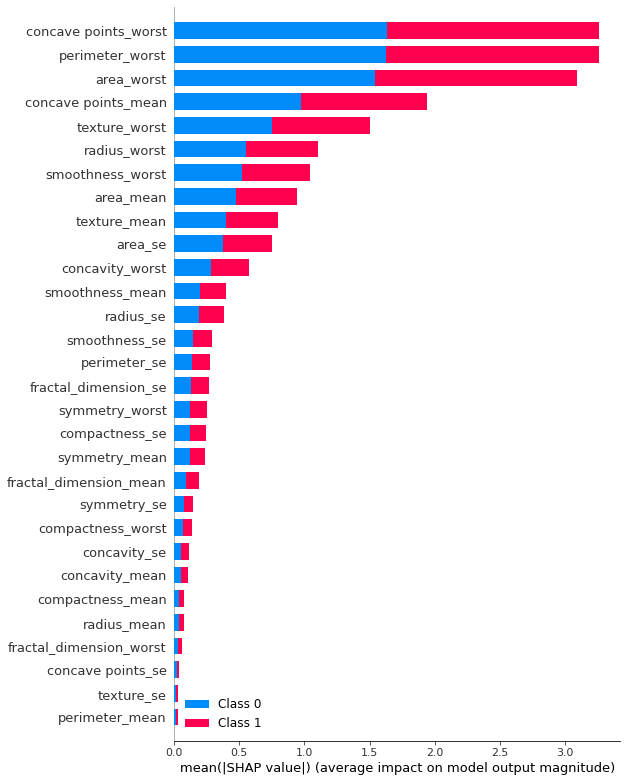

In [79]:
shap.summary_plot(shap_values, x_train, max_display=len(x.columns))

In [80]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(x_train.columns, sum(vals))),columns=['feature_name','importance_value'])
feature_importance.sort_values(by=['importance_value'],ascending=False,inplace=True)
feature_importance.to_csv('./results/shap-lightgbm.csv')

print(feature_importance.to_latex())

\begin{tabular}{llr}
\toprule
{} &             feature\_name &  importance\_value \\
\midrule
27 &     concave points\_worst &        648.868212 \\
22 &          perimeter\_worst &        648.513804 \\
23 &               area\_worst &        614.950634 \\
7  &      concave points\_mean &        386.655820 \\
21 &            texture\_worst &        298.478496 \\
20 &             radius\_worst &        220.591554 \\
24 &         smoothness\_worst &        208.316914 \\
3  &                area\_mean &        188.055671 \\
1  &             texture\_mean &        158.343546 \\
13 &                  area\_se &        149.098586 \\
26 &          concavity\_worst &        114.572291 \\
4  &          smoothness\_mean &         79.810131 \\
10 &                radius\_se &         75.992063 \\
14 &            smoothness\_se &         57.357958 \\
12 &             perimeter\_se &         55.716858 \\
19 &     fractal\_dimension\_se &         53.385736 \\
28 &           symmetry\_worst &         

In [81]:
import os

measures_data = []
featured_names = []

def print_classification_report(classification_report):
    accuracy = classification_report["accuracy"]
    precision = classification_report["weighted avg"]["precision"]
    f1_score = classification_report["weighted avg"]["f1-score"]
    recall = classification_report["weighted avg"]["recall"]
    
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"F1 Score: {f1_score}")
    print(f"Recall: {recall}")
    print(f"Training time: {(stop - start) * 1000 }s")

def get_measures(feature, classification_report, training_time, shap_value, storage): 
    accuracy = classification_report["accuracy"]
    precision = classification_report["weighted avg"]["precision"]
    f1_score = classification_report["weighted avg"]["f1-score"]
    recall = classification_report["weighted avg"]["recall"]
    
    measures_data.append([feature, accuracy, precision, recall, f1_score, training_time, shap_value, storage])

def train_model(feature, shap_value):
    featured_names.append(feature)

    x = df[featured_names]
    y = df['diagnosis'].map({"M": 0, "B": 1})

    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7)

    start = time.time()
    model = LGBMClassifier()
    model.fit(x_train, y_train)
    stop = time.time()
    
    pred = model.predict(x_test)
    
    storage = get_storage(featured_names)
    training_time = (stop - start) * 1000
    classification = classification_report(y_test, pred, output_dict=True)
    get_measures(feature, classification, training_time, shap_value, storage)
    
def get_storage(features):
    merged_features = ['diagnosis', 'id', 'Unnamed: 32'] + features
    temp = df[merged_features]
    temp.to_csv('./dataset/temp.csv')
    
    return os.stat('./dataset/temp.csv').st_size
            
def shap_all(df):
    for index, row in df.iterrows():
        train_model(row['feature_name'], row['importance_value'])

In [82]:
shap_all(feature_importance)

measures_df = pd.DataFrame(measures_data, columns = ['Feature Name', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time', 'Shap Value', 'Storage'])

measures_df.to_csv('./results/lightgbm/cancer-breast-lightgbm-report.csv')

In [83]:
measures_df.head()

,Feature Name,Accuracy,Precision,Recall,F1 Score,Training Time,Shap Value,Storage
0,concave points_worst,0.871345,0.872060,0.871345,0.869643,343.100786,648.868212,12290
1,perimeter_worst,0.906433,0.907222,0.906433,0.905643,294.098139,648.513804,15686
2,area_worst,0.923977,0.926995,0.923977,0.924654,141.578913,614.950634,19264
3,concave points_mean,0.947368,0.947927,0.947368,0.946699,178.008080,386.655820,23697
4,texture_worst,0.959064,0.959368,0.959064,0.958906,155.719042,298.478496,27062


In [84]:
import matplotlib.pyplot as plt

# Performance

def show_accuracy_chart(df):
    temp_1 = df['Accuracy'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Accuracy (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/lightgbm/lightgbm-accuracy.png')

def show_precision_chart(df):
    temp_1 = df['Precision'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Precision (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/lightgbm/lightgbm-precision.png')
    
def show_recall_chart(df):
    temp_1 = df['Recall'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Recall (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/lightgbm/lightgbm-recall.png')
    
def show_f1_score_chart(df):
    temp_1 = df['F1 Score'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("F1 Score (%)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/lightgbm/lightgbm-f1-score.png')
    
# Storage
    
def show_storage_chart(df):
    temp_1 = df['Storage'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Storage (bytes)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/lightgbm/lightgbm-storage.png')
    
# Training Time
    
def show_training_chart(df):
    temp_1 = df['Training Time'].tolist()
    temp_2 = list(range(1,31))
    plt.xlabel("Number of features")
    plt.ylabel("Time (ms)")
    plt.plot(temp_2, temp_1)
    plt.savefig('./results/lightgbm/lightgbm-training-time.png')

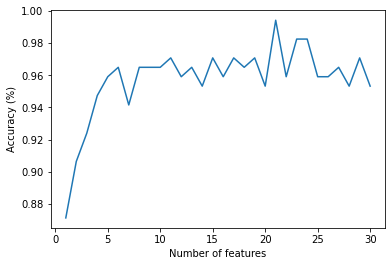

In [85]:
show_accuracy_chart(measures_df)

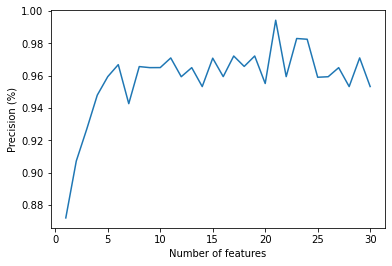

In [86]:
show_precision_chart(measures_df)

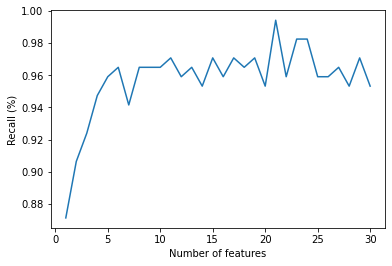

In [87]:
show_recall_chart(measures_df)

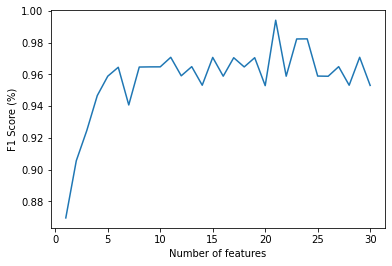

In [88]:
show_f1_score_chart(measures_df)

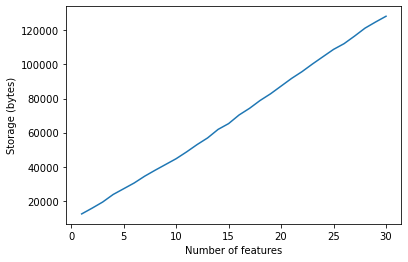

In [89]:
show_storage_chart(measures_df)

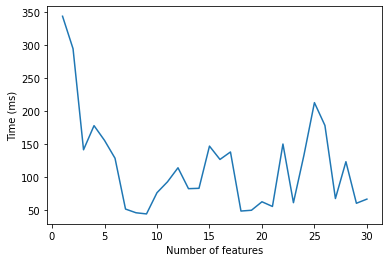

In [90]:
show_training_chart(measures_df)